In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import autokeras as ak
import os
import tensorflow as tf
import time

In [2]:
data = np.load('/work/n1000000_0804_all_flat.npz')
cut_index = np.load('/work/NIO_largerthan1000_index.npy')

In [3]:
input_state = 2
target = data['theta23']
if input_state == 0:
    data_all = data['ve_dune']
elif input_state == 1:
    data_all = np.column_stack([data['ve_dune'], data['vu_dune'], data['vebar_dune'], data['vubar_dune']])
elif input_state == 2:
    data_all = np.column_stack([data['ve_dune'], data['vu_dune'], data['vebar_dune'], data['vubar_dune'], data['ve_t2hk'], data['vu_t2hk'], data['vebar_t2hk'], data['vubar_t2hk']])

x_train = data_all[:10000, cut_index]
y_train = target[:10000]
x_train2 = data_all[10000:900000, cut_index]
y_train2 = target[10000:900000]
x_test = data_all[900000:, cut_index]
y_test = target[900000:]

In [4]:
generate = 10
num_of_bins = len(x_train[0])
x_train_gen = np.reshape(np.random.normal(x_train, np.sqrt(x_train), size = (generate, len(x_train), num_of_bins)), (generate*len(x_train), num_of_bins))
y_train_gen = np.repeat(y_train, generate)
x_train2_gen = np.reshape(np.random.normal(x_train2, np.sqrt(x_train2), size = (generate, len(x_train2), num_of_bins)), (generate*len(x_train2), num_of_bins))
y_train2_gen = np.repeat(y_train2, generate)
x_test_gen = np.reshape(np.random.normal(x_test, np.sqrt(x_test), size = (generate, len(x_test), num_of_bins)), (generate*len(x_test), num_of_bins))
y_test_gen = np.repeat(y_test, generate)

In [5]:
clf = ak.StructuredDataRegressor(overwrite=True, max_trials=50)
clf.fit(x_train_gen, y_train_gen,
           validation_split = 0.1,
           batch_size=64,
           epochs=20,
           verbose=1,
           shuffle = True
       )

Trial 1 Complete [00h 00m 07s]
val_loss: 20.77654266357422

Best val_loss So Far: 20.77654266357422
Total elapsed time: 00h 00m 07s
INFO:tensorflow:Oracle triggered exit

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1563/1563 [==============================] - 4s 3ms/step - loss: 177.5945 - mean_squared_error: 177.5945
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.

In [6]:
model = clf.export_model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 17)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 17)                0         
_________________________________________________________________
normalization (Normalization (None, 17)                35        
_________________________________________________________________
dense (Dense)                (None, 32)                576       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)               

In [7]:
model.fit(x_train2_gen, y_train2_gen,
           validation_split = 0.1,
           batch_size=64,
           epochs=20,
           verbose=1,
           shuffle = True
         )

125157/125157 [==============================] - 295s 2ms/step - loss: 12.6107 - mean_squared_error: 12.6107 - val_loss: 12.4487 - val_mean_squared_error: 12.4487


In [8]:
model.evaluate(x_test_gen, y_test_gen)
pre_test = model.predict(x_test_gen)

31250/31250 [==============================] - 60s 2ms/step - loss: 12.4866 - mean_squared_error: 12.4866


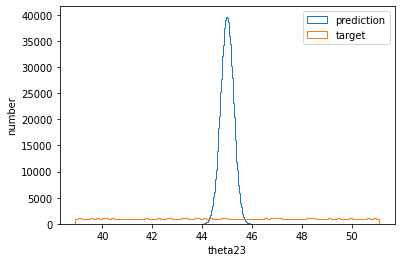

In [9]:
plt.hist(pre_test, histtype = 'step', bins = 100, label = 'prediction')
plt.hist(y_test, histtype = 'step', bins = 100, label = 'target')
plt.xlabel('theta23')
plt.ylabel('number')
plt.legend()
plt.show()

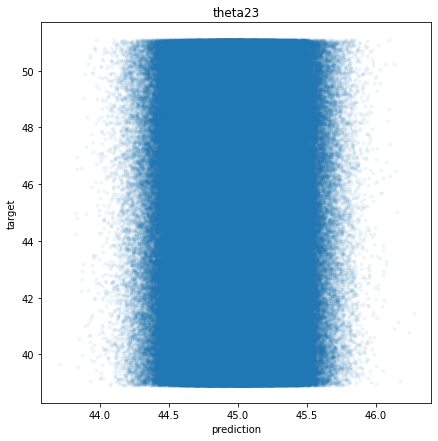

In [13]:
plt.figure(figsize=(7,7))
plt.plot(pre_test[:,0], y_test_gen, '.', alpha = 0.05)
plt.xlabel('prediction')
plt.ylabel('target')
plt.title('theta23')
plt.show()

In [14]:
if input_state == 0:
    modelname = '/work/Regression/models_ve_dune/0803_theta23_1.h5'
    if not os.path.isfile(modelname):
        model.save(modelname)
elif input_state == 1:
    modelname = '/work/Regression/models_all_dune/0803_theta23_1.h5'
    if not os.path.isfile(modelname):
        model.save(modelname)
elif input_state == 2:
    modelname = '/work/ML4NO/ML/Regression/perturb_cut/0804_cut1000_theta23_1.h5'
    if not os.path.isfile(modelname):
        model.save(modelname)